# Интерполяция временных рядов

## Проблема недостающих значений

Как только недостоверные данные идентифицированы и отброшены, самым важным шагом подготовки данных становится решение проблемы неполных данных.

Внесение значений взамен недостающих должно осуществляться с особой осторожностью, чтобы не нарушить закономерности, скрытые в существующих данных.


Многим из тех, кто сталкивается с научными и инженерными расчётами, часто приходится оперировать наборами значений, полученных опытным путём или методом случайной выборки. Как правило, на основании этих наборов требуется построить функцию, на которую могли бы с высокой точностью попадать другие получаемые значения. Такая задача называется **аппроксимацией**.

**Интерполяцией** называют такую *разновидность* аппроксимации, при которой кривая построенной функции проходит точно через имеющиеся точки данных.



Рассмотрим несколько методов интерполяции данных:

In [1]:
#Для начала подгрузим необходимые модули и сами данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Данные ищите здесь:

https://goo.su/s4BI - данные о температуре и потребляемой мощности электрической энергии (раноотстоящие узлы)

https://goo.su/7RVdDzK - данные о стоимости доллара и нефти (не равноотстоящие узлы)

In [3]:
# TODO: загрузите CSV файлы
data1 = pd.read_csv('./DataSet3_1.csv', sep=",") # данные о температуре и потребляемой мощности электрической энергии (раноотстоящие узлы)


In [4]:
# традиционно, сначала посмотрим на данные
# очевидно, данные представляют собой показания датчиков температуры и напряжения
data1.tail()
#OAT = Oudside Air Temperature

,Timestamp,OAT (F),Power (kW)
34935,12/30/2010 23:00,47,285.8
34936,12/30/2010 23:15,44,206.6
34937,12/30/2010 23:30,44,205.9
34938,12/30/2010 23:45,44,189.4
34939,12/31/2010 0:00,44,177.9


In [6]:
data1['Timestamp'] = pd.to_datetime(data1['Timestamp'], format='%m/%d/%Y %H:%M')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34940 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   34940 non-null  datetime64[ns]
 1   OAT (F)     34940 non-null  int64         
 2   Power (kW)  34940 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 819.0 KB


In [7]:
# TODO: проверьте, какого типа данные хранятся в колонках датафрема и, при необходимости, преобразуйте их
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34940 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Timestamp   34940 non-null  datetime64[ns]
 1   OAT (F)     34940 non-null  int64         
 2   Power (kW)  34940 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 819.0 KB


## Интерполяция

#### Интерполяция для равноотстоящих точек

In [11]:
# TODO: Для построения интерполяционной кривой выбираем неольшой отрезок [10:25]
x = data1['Timestamp'][10:25]
x = (data1['Timestamp'][10:25] - data1['Timestamp'].loc[0]) // pd.Timedelta('1s')

y = data1['Power (kW)'][10:25]



# # Массив значений x1, которые мы хотим интерполировать
x1 = np.arange(x.values[0], x.values[-1], 1) #start, stop, step
# x1

### Линейная интерполяция

**Линейная интерполяция** — это метод оценки значений функции между двумя известными точками. Этот метод предполагает, что между двумя точками можно провести прямую линию, и значение функции в любой промежуточной точке можно найти, используя уравнение этой прямой.

Формула линейной интерполяции имеет вид:

$f(x)=f(x_{i}) + \frac{f(x_{i+1})-f(x_{i})}{x_{i+1}-x_{i}} (x-x_{i})$, при $x_{i} \leq x \leq x_{i+1}$

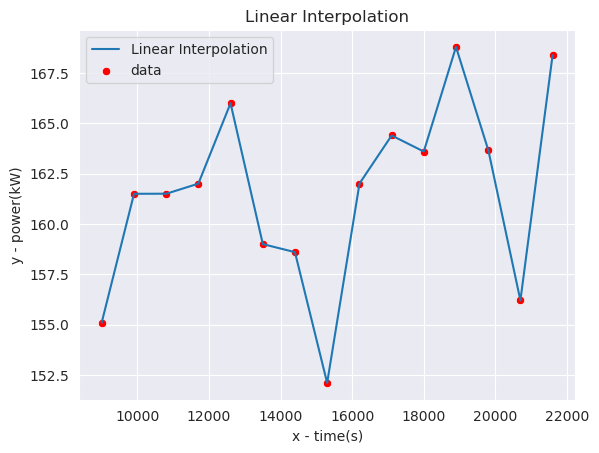

In [12]:
Linear = np.interp(x=x1, xp=x, fp=y)


sns.set_style("darkgrid")
# График линейной интерполяции
sns.lineplot(x=x1, y=Linear, label="Linear Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="red", marker="o", label='data')

# Заголовок и подписи осей
plt.xlabel("x - time(s)")
plt.ylabel("y - power(kW)")
plt.title("Linear Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

К сожалению, построенная таким образом аппроксимирующая кусочно-линейная функция не обладает *гладкостью* (первая производная этой функции терпит разрывы в узлах стыка полученных прямых). Поэтому рассмотрим другие методы интерполяции.

### Кубический сплайн

Попробуем использовать многочлены и строить интерполяционную функцию последовательно, звено за звеном. В результате получится так называемый полиномиальный многозвенник.

При таком подходе важно правильно выбрать степени привлекаемых многочленов, а для гладкости получаемой кривой необходимо тщательно подобрать коэффициенты многочленов (из условий гладкого сопряжения соседних звеньев). Результат применения такого подхода называют *сплайн-функциями* или просто *сплайнами*.

**Интерполяционным кубическим сплайном** называется функция $S(x)$ , обладающая следующими свойствами:

- график этой функции проходит через каждую точку заданного набора точек $S(x_{i})=y_{i}, \forall i$;

- на каждом из отрезков $[x_{i}, x_{i+1}], i=1,..,n-1$ функция является многочленом третьей степени;

- на всем отрезке задания $[x_{0}, x_{n}]$ функция $S(x)$ имеет непрерывную вторую производную.

In [ ]:
from scipy.interpolate import CubicSpline

# Наши данные x, y, и x1
f_cubic = CubicSpline(x, y)
S = f_cubic(x1)

# График кубической интерполяции
sns.lineplot(x=x1, y=S, label="Cubic Spline Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="red", marker="o", label='data')

# Заголовок и подписи осей
plt.xlabel("x - time(s)")
plt.ylabel("y - power(kW)")
plt.title("Cubic Spline Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

In [ ]:
# Получение коэффициентов
coefficients = f_cubic.c  # Коэффициенты сплайна

print("Коэффициенты кубического сплайна:")
print(coefficients)

### Интерполяционная формула Лагранжа

Пусть функция $f$ задана таблицей.

Интерполяционный полином Лагранжа позволяет находить значение функции в точках, которые не были заданы, на основе известных значений в узловых точках. Полином Лагранжа $P(x)$ для $n+1$ узлов $(x_{0}, y_{0})$, $(x_{1}, y_{1})$, ..., $(x_{n}, y_{n})$ записывается в следующем виде:

$P(x) = \sum_{i=0, n} y_{i}L_{i}(x)$,

где $L_{i}(x)$ - это базисные полиномы Лагранжа, определяемые как:

$L_{i}(x) =
\prod_{\substack{0 \leq j \leq n \\ j \neq i}} \frac {x - x_{j}}{x_{i}-x_{j}}
$


где $y_i$ — значение функции в узловой точке $x_i$

$L_{i}(x)$ - полином, который равен 1 в точке $x_i$ и 0 в остальных узловых точках $x_j$ ($j≠i$)

После преобразований получим:

$L_{n} = \sum_{i=0, n} y_{i} \frac {(x - x_{0})* ... *(x - x_{n})} {(x_{i}-x_{0})*...*(x_{i}-x_{n})}$

Полученное выражение называют **интерполяционным полиномом Лагранжа**.

In [ ]:
x, y = np.array(x), np.array(y)

In [ ]:
def lagrange_interpolation(x_values, y_values, x):
    #TODO Дополнительное задание:
    #напишите код функции, вычисляющей значения коэффициентов полинома Лагранжа
    '''
    x_values: значения по x
    y-values: значения по y
    x: значения по оси x

    функция должна возвращать значение по y для построения графика
    '''


# Generate points for plotting the interpolated curve
y1 = [lagrange_interpolation(x, y, x_i) for x_i in x1]


#TODO: Постройте график по полученным значениям. Не забудьте нанести на график точки x, y!

Функция krogh_interpolate названа в честь Бенжамина Кроха (B. Krogh), который разработал эффективные алгоритмы для полиномиальной интерполяции и численного дифференцирования. Эти алгоритмы были представлены в работе, опубликованной в 1970 году.

Функция krogh_interpolate позволяет создавать интерполяционный полином, который проходит через заданные точки, а также может учитывать производные в этих точках.  Функция принимает массивы значений $x$ и $y$ (известные точки) и может дополнительно принимать значения производных в этих точках. Это позволяет строить более точные и гладкие полиномы, чем при использовании стандартной полиномиальной интерполяции, такой как метод Лагранжа.

In [ ]:
from scipy.interpolate import krogh_interpolate
lagrange_interp = krogh_interpolate(x, y, x1)

# График интерполяции Лагранжа
sns.lineplot(x=x1, y=lagrange_interp , label="Krogh Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="red", marker="o", label='Data Points')

# Заголовок и подписи осей
plt.xlabel("x - time(s)")
plt.ylabel("y - power(kW)")
plt.title("Krogh Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

### Формула Ньютона

Для функции с неравноотстоящими точками интерполяция может осуществляться по формуле Ньютона. В формуле Ньютона для неравноотстоящих узлов используются выражения, которые называют разделенными разностями.

![image.png](attachment:image.png)

В приведенных формулах $x_{i}, y_{i}$ — значения аргумента и функции в узловых точках.

Запишем через разделенные разности интерполяционную формулу Ньютона для неравноотстоящих узловых точек:

$P(x)=y_{0}+[x_{0}, x_{1}](x-x_{0})+...+[x_{0},x_{1},...,x_{n}](x-x_{0})(x-x_{1})...(x-x_{n})$

In [ ]:
def divided_differences(x, y):
    """
    Вычисление разделённых разностей
    x: список или np array содержащий значения по x
    y: список или np array содержащий значения по y

    return ...: коэффициенты при членах полинома Ньютона
    """
    n = len(y)
    coef = np.zeros([n, n])
    coef[:, 0] = y  # Первый столбец - значения функции

    for j in range(1, n):
        for i in range(n - j):
            #TODO: Реализуйте вычисление коэффициента
            pass

    return ... # Возвращаем коэффициенты полинома

def newton_interpolation(x, y, x_value):
    """
    x: данные по x
    y: данные по y
    x_value: точка в которой сейчас строим полином

    return p: значение по y в точке x
    """
    # инициализация переменных
    coef = divided_differences(x, y)
    n = len(coef)
    p = coef[0]

    for i in range(1, n):
        #TODO: реализуте вычисление p
        pass

    return p

# Вычислите значения интерполяционного полинома для новых x1
y_interp =  [newton_interpolation(x, y, x_i) for x_i in x1]

# График интерполяции Лагранжа
sns.lineplot(x=x1, y=y_interp, color="black", label="Newton Interpolation")

# Диаграмма рассеяния данных
sns.scatterplot(x=x, y=y, color="green", marker="o", label="Data")

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Newton Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

### Бонус:
#### Метод .interpolate() объектов Series/DataFrame в pandas

Заполняет значения NaN, используя метод интерполяции.
Синтаксис:

In [ ]:
df = DataFrame.interpolate(method='linear', axis=0, limit=None,
                          inplace=False, limit_direction=None,
                          limit_area=None, downcast=None, **kwargs)

s = Series.interpolate(method='linear', limit=None, inplace=False,
                       limit_direction=None, limit_area=None, downcast=None, **kwargs)

Подробнее, например, тут https://docs-python.ru/packages/modul-pandas-analiz-dannykh-python/interpolate-series-dataframe/

In [ ]:
s = pd.Series([1, 1, 2, np.nan, 5, np.nan, 13])

In [ ]:
s.interpolate()

In [ ]:
# сработает только при налиции NaN!!!
data1['Power (kW)'].interpolate(method='spline', order=3)

Отвлечёмся на маленькое задание:

Пройдите, пожалуйста, тест!

<a href="http://www.stqr.ru/qrcodes/QR-code_url_23_Sep_2024_16-37-33.svg" alt="qr code"><img src="http://www.stqr.ru/qrcodes/QR-code_url_23_Sep_2024_16-37-33.svg" width=400 height=400></a>

Итак, Ваше задание:

1) Скачать файлы данных или подобрать свои (https://disk.yandex.ru/d/ADpRgSJX_uJ4qQ )
   - DataSet3_1 – Данные о частоте и потребляемой мощности электрической энергии офисным зданием (регулярный временной ряд)
      - Timestamp - дата в формате мм/дд/гггг чч:мм
      - OAT (F) - Outside Air Temperature — температура наружного воздуха, в градусах Фаренгейта.
      - Power (kW) - Мощность в киловаттах
   - DataSet3_2 – данные о курсе доллара и стоимости барреля нефти (нерегулярный временной ряд)
      - Data - дата в формате дд.мм.гггг
      - Dollar - стоимость 1 доллара в этот день
      - Oil Brent - стоимость одного барреля нефти Oil Brent  

Взять не менее 10 значений и построить по ним интерполяционные кривые
   - по формуле Лагранжа
   - по формуле Ньютона
   - с использованием сплайнов (интерполяция кубическим сплайном)

*Дополнительные баллы:*
1) Свой файл данных
2) Продолжить интерполяционные кривые за пределы рассматриваемого интервала
3) Реализовать построение кривых без использования встроенных функций/библиотек

---